In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from keras.layers import Input, Dense, Conv2D, Flatten
from keras.models import Model
from keras.utils import to_categorical

# Helper libraries
import numpy as np
import random
from math import ceil 

from scipy import signal
from scipy import misc

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

C:\Users\kheniv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kheniv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kheniv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kheniv\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [3]:
plt.rcParams["figure.figsize"] = (15,10)
print(tf.__version__)

1.14.0


A simple plotting routine to show grey-scale images.

In [4]:
def plotGreyScaleImage(image, ax=None, title=None, hide_axis=True, show_grid=False, show=True):
    # create new plot, if no ax is given
    if ax is None: ax = plt.subplot(1,1,1)
    if hide_axis: ax.set_axis_off()
    if title: ax.set_title(title)
    # plot the image
    im=ax.imshow(image, cmap='copper')
    plt.grid(show_grid)
    # add the colorbar to the plot ...
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im,cax=cax)
    if show:
        plt.show()

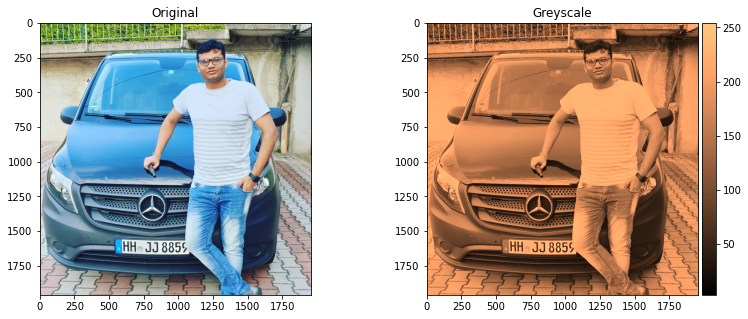

In [5]:
image = plt.imread("kheni.jpg")
#image = image[:100,:100]

f, (ax1,ax2) = plt.subplots(1,2,figsize=(13,5))
ax1.imshow(image)
ax1.set_title("Original")

# turn it into a grey-scale image
image = np.mean(image,-1)

plotGreyScaleImage(image,ax2,title="Greyscale",hide_axis=False)

We can implement a 2d-Convolution as a simple nested for-loop:

In [6]:
def conv2d(image, kernel):
    # get width and height of image and kernel
    (iw, ih), (kw, kh) = image.shape, kernel.shape
    tw = iw - kw + 1
    th = ih - kh + 1
    
    # create an empty result image
    res = np.nan * np.zeros((iw,ih))
    
    # iterate over all pixels of the image
    for ix, iy in np.ndindex((tw, th)):
        res[ix][iy] = 0
        # iterate over all pixels of the kernel
        for kx, ky in np.ndindex((kw, kh)):
            # if the source pixel is part of the image ...
            if ix+kx<iw  and  iy+ky<ih:
                # ... compute product of kernel and pixel and add to result
                res[ix][iy] += image[ix+kx][iy+ky]*kernel[kx][ky]

    return res

# Edge detection by Convolution

[[ 0.  0.  0. nan]
 [ 1.  0. -1. nan]
 [ 1.  0. -1. nan]
 [ 0.  0.  0. nan]]
[[ 0.  1.  1.  0.]
 [ 0.  0.  0.  0.]
 [ 0. -1. -1.  0.]
 [nan nan nan nan]]


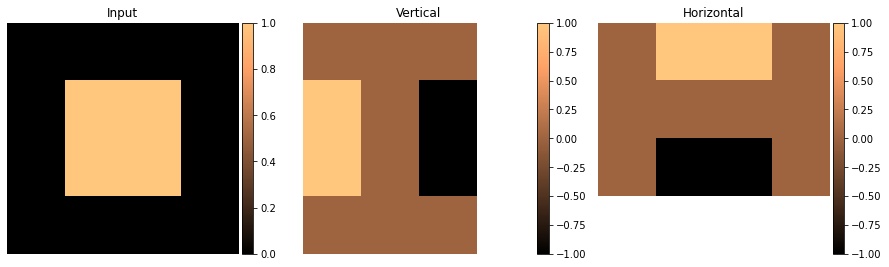

In [7]:
kernel1 = np.array([[-1.0,1.0]])   # a vertical edge detector
kernel2 = np.array([[-1.0],[1.0]]) # a horizontal edge detector

im = np.array(
    [[0.0,0.0,0.0,0.0],
     [0.0,1.0,1.0,0.0],
     [0.0,1.0,1.0,0.0],
     [0.0,0.0,0.0,0.0]])

result1 = conv2d(im, kernel1)
print(result1)

result2 = conv2d(im, kernel2)
print(result2)

_, axs = plt.subplots(1, 3, sharey=True)

plotGreyScaleImage(im,      ax=axs[0], title="Input", show=False)
plotGreyScaleImage(result1, ax=axs[1], title="Vertical", show=False)
plotGreyScaleImage(result2, ax=axs[2], title="Horizontal")

Using the simple implementation, we can convolve the image using simple kernels.

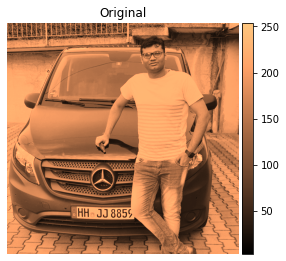

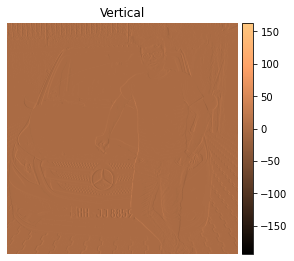

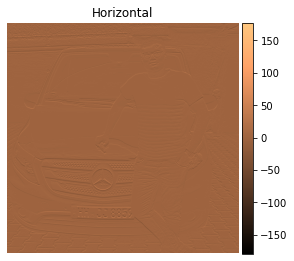

In [8]:
kernel1 = np.array([[-1.0,1.0]])   # a vertical edge detector
kernel2 = np.array([[-1.0],[1.0]]) # a horizontal edge detector

result1 = conv2d(image, kernel1)
result2 = conv2d(image, kernel2)

plotGreyScaleImage(image,  plt.subplot(131), title="Original")
plotGreyScaleImage(result1,plt.subplot(132), title="Vertical")
plotGreyScaleImage(result2,plt.subplot(133), title="Horizontal")

A little helper functions to create an average kernel for simple bluring. 

In [13]:
def blurKernel(s):
    k = np.empty((s,s))
    k.fill(1/(s*s))
    return k

The following function will apply a given kernel to an image and plot the resulting image. 

In [14]:
def applyKernel(image, kernel, ax=None, title=None, hide_axis=True):
    res = signal.convolve2d(image, kernel, boundary='fill', mode='valid')

    # plot it
    if ax is None: ax = plt.subplot(1,1,1)
    if hide_axis: ax.set_axis_off()
    im = ax.imshow(res, cmap='copper')
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im,cax=cax)
    if title: ax.set_title(title)
    return res

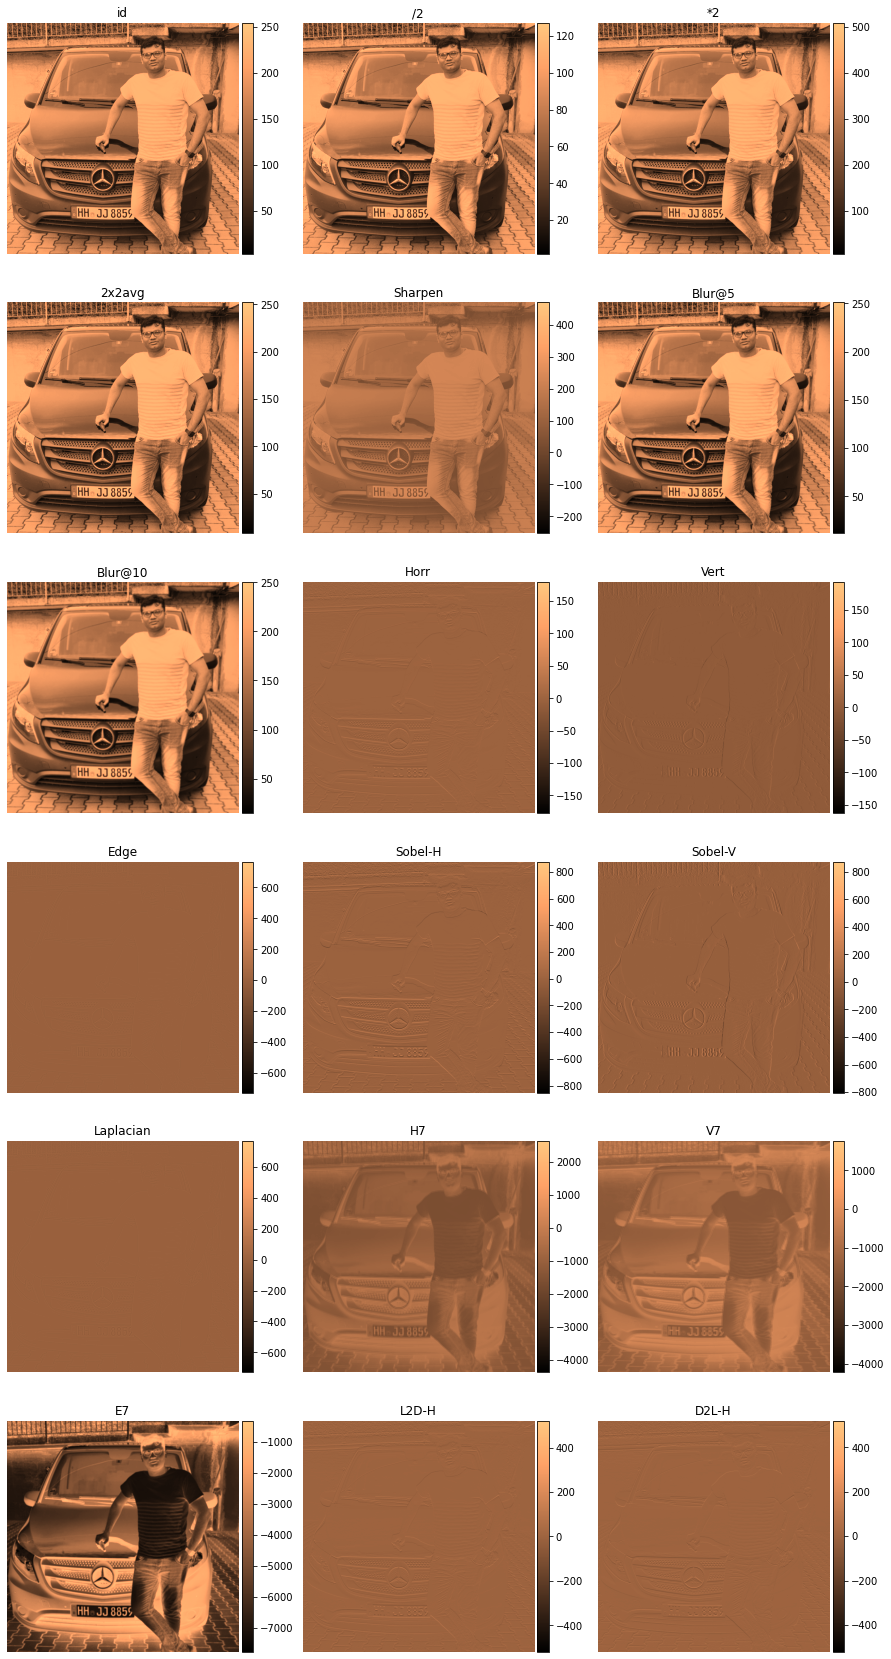

In [19]:
kernels = {
    "id":        np.array([[1]]),
    "/2":        np.array([[0.5]]),
    "*2":        np.array([[2]]),
    "2x2avg":    np.array([[0.25, 0.25],
                           [0.25, 0.25]
                          ]),
    "Sharpen":   np.array([[0, 0, 0, 0, 0],
                           [0, 0,-1, 0, 0],
                           [0,-1, 5,-1, 0],
                           [0, 0,-1, 0, 0],
                           [0, 0, 0, 0, 0],
                          ]),
    "Blur@5":    blurKernel(5),
    "Blur@10":   blurKernel(10),
    "Horr":      np.array([[-1],       [1]                   ]),
    "Vert":      np.array([[-1.0,1.0]                        ]),
    "Edge":      np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1] ]),
    "Sobel-H":   np.array([[-1,-2,-1], [0,0,0],   [1,2,1]    ]),
    "Sobel-V":   np.array([[-1,0,1],   [-2,0,2],  [-1,0,1]   ]),
    "Laplacian": np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1] ]),
    "H7":        np.array([[-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [1,1,1,1,1,1,1],
                           [-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1],
                          ]),
    "V7":        np.array([[-1,-1,1,1,1,-1,-1],
                           [-1,-1,1,1,1,-1,-1],
                           [-1,-1,1,1,1,-1,-1],
                           [-1,-1,1,1,1,-1,-1],
                           [-1,-1,1,1,1,-1,-1],
                           [-1,-1,1,1,1,-1,-1],
                           [-1,-1,1,1,1,-1,-1],
                          ]),
    "E7":        np.array([[-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1, 1, 1, 1,-1,-1],
                           [-1,-1, 1, 1, 1,-1,-1],
                           [-1,-1, 1, 1, 1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1],
                           [-1,-1,-1,-1,-1,-1,-1],
                          ]),
    "L2D-H":     np.array([[-1,-1,-1], [1,1,1]               ]),
    "D2L-H":     np.array([[1,1,1],    [-1,-1,-1]            ])
}

results = {}

fs = 5
nkr = 3
nk = len(kernels)
nkx = min(nkr, nk)
nky = ceil(nk / nkx)
plt.figure(figsize=(nkx*fs, nky*fs))

for i,(name, kernel) in enumerate(kernels.items()):
    results[name] = applyKernel(image, kernel, title=name, ax=plt.subplot(nky,nkx,i+1))
    
plt.show()

----
# Lets get back to the MNIST dataset ...


In [15]:
data = keras.datasets.mnist
(tr_X, tr_l), (te_X, te_l) = data.load_data()
tr_X = tr_X / 255.0
te_X = te_X / 255.0

tr_X = tr_X.reshape(60000,28,28,1)
te_X = te_X.reshape(10000,28,28,1)

tr_Y = to_categorical(tr_l)
te_Y = to_categorical(te_l)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
#create model

num_features = 5
kernel_size = 3

model = Sequential()
model.add(Conv2D(num_features, kernel_size=kernel_size, activation='relu', input_shape=(28,28,1)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 5)         50        
_________________________________________________________________
flatten (Flatten)            (None, 3380)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                33810     
Total params: 33,860
Trainable params: 33,860
Non-trainable params: 0
_________________________________________________________________


In [17]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', 'mean_squared_error'])

In [18]:
#train the model
model.fit(tr_X, tr_Y, validation_data=(te_X, te_Y), epochs=5, batch_size=1024)


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 69us/step - loss: 1.0473 - categorical_accuracy: 0.7543 - mean_squared_error: 0.0451 - val_loss: 0.4161 - val_categorical_accuracy: 0.8910 - val_mean_squared_error: 0.0181
Epoch 2/5
60000/60000 [==============================] - 4s 66us/step - loss: 0.3616 - categorical_accuracy: 0.8985 - mean_squared_error: 0.0159 - val_loss: 0.2978 - val_categorical_accuracy: 0.9189 - val_mean_squared_error: 0.0128
Epoch 3/5
60000/60000 [==============================] - 4s 74us/step - loss: 0.2926 - categorical_accuracy: 0.9173 - mean_squared_error: 0.0128 - val_loss: 0.2639 - val_categorical_accuracy: 0.9242 - val_mean_squared_error: 0.0115
Epoch 4/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.2602 - categorical_accuracy: 0.9267 - mean_squared_error: 0.0114 - val_loss: 0.2399 - val_categorical_accuracy: 0.9330 - val_mean_squared_error: 0.0105
Epoch 5/5
60000/60000

---
# Analysing the size of the network
First, we look at input and output of the model.
It should accept 28x28 images with 1 channel and output a distribution over the 10 classes.
I.e., the input tensor should have the shape `(?, 28, 28, 1)` and the output should have shape `(?, 10)`.

In [20]:
print("Input: ", model.input)
print("Output:", model.output)

Input:  Tensor("conv2d_1_input:0", shape=(?, 28, 28, 1), dtype=float32)
Output: Tensor("dense_1/Softmax:0", shape=(?, 10), dtype=float32)


Next, we will look at the shape of the weight matrices.
The following code, will print the shape of the weight matrix for every layer. This contains the weights to the previous layer as well as the biases. Please note, the Flatten layer has no weights, but just reshapes the inputs, therefore only weights for layer `0` and `2` will be printed. In addition, a small summary of the shapes and number of trainable parameters is shown.

In [21]:
for il,l in enumerate(model.layers):
    print("Layer %i: '%s'" % (il, l.name))
    for iw,w in enumerate(l.get_weights()):
        print(" - Weight", iw, w.shape)

model.summary()

Layer 0: 'conv2d_1'
 - Weight 0 (3, 3, 1, 5)
 - Weight 1 (5,)
Layer 1: 'flatten_1'
Layer 2: 'dense_1'
 - Weight 0 (3380, 10)
 - Weight 1 (10,)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 5)         50        
_________________________________________________________________
flatten_1 (Flatten)          (None, 3380)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                33810     
Total params: 33,860
Trainable params: 33,860
Non-trainable params: 0
_________________________________________________________________


--- 
# Which features have been learned?

What has been learned here? Can we plot the weights to the convolutional layer as images? They correspond to the feature maps = kernel (as shown in the convolution example above).

[[-0.10022123  0.30124193 -0.06626517]
 [ 0.01386076  0.38276386  0.05428796]
 [ 0.19552739  0.04923251 -0.09571251]]


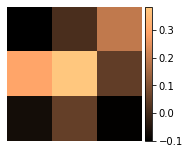

[[-0.23688625  0.14666624  0.12350474]
 [ 0.23382553  0.26526475  0.00392586]
 [ 0.2157989   0.37626037  0.32006368]]


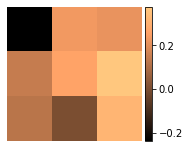

[[-0.11852453 -0.47875747 -0.44811824]
 [-0.058173   -0.09766324  0.37532112]
 [ 0.19837883  0.4210509   0.06913792]]


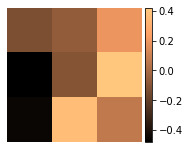

[[ 0.13044772 -0.20218061  0.26606253]
 [-0.02821461  0.38012356 -0.06908394]
 [ 0.2724684  -0.05578345  0.18281128]]


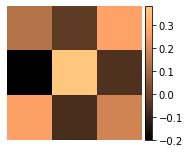

[[ 0.17694496  0.12910736 -0.36015835]
 [ 0.2608297   0.12810217  0.05657013]
 [ 0.2565733  -0.17893656 -0.3780008 ]]


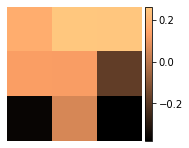

In [22]:
for i,im in enumerate(model.get_weights()[0].transpose()):
    print(im[0])
    plotGreyScaleImage(im[0].transpose(),  plt.subplot(1,num_features,i+1))